In [91]:
from torch import nn
import numpy as np
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import skimage.io as io
import PIL.Image
from tqdm import tqdm, trange
import torch.nn.functional as nnf
import clip
from joblib import load
import librosa
from hmmlearn import hmm
import os
import sounddevice as sd
import numpy as np
import librosa
import joblib
from tqdm import tqdm 
import soundfile as sf
from enum import Enum
import cv2

In [92]:
from speechtriggerclassifierMLP import SpeechTriggerClassifier

In [3]:
import torch
import torchaudio

In [4]:
import IPython
import matplotlib.pyplot as plt

In [5]:
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]

In [6]:
D = torch.device
CPU = torch.device('cpu')

The portion responsible for initialization of the captioning model. (This is taken from the CLIPcap codebase)

In [121]:
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

The portion responsible for generating the next word, using the predictions returned by CLIP. These functions are present in the GPT-2 source code, and represent different strategies to generate descriptions. 

In [140]:
def generate1(model, tokenizer, beam_size: int = 7, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [123]:
def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')

In [124]:
CUDA = get_device
is_gpu = True

In [98]:
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Loading all of the pretrained weights, and intializing the model for use.

In [152]:
model_path = "../CLIP_prefix_caption/coco_train/model_wieghts.pt"
prefix_length = 10

model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False) 
model = model.eval() 
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

C:\conda_temp\ipykernel_8344\1076736708.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False)


In [153]:
def get_viable_logits(logits, threshold=0.05):
    probs = torch.softmax(logits, dim=-1)
    viable_logits_count = (probs > threshold).sum().item()
    return viable_logits_count

A debugging function, for testing the generation pipeline, based on the predictions returned by the CLIP model. (predictions with relatively low values can infect the caption, so we need to rid of those. This function sets a threshold, and eliminated all the other probability values.)

In [165]:
def generation_(logits, fn2, fn1, model, tokenizer, threshold=0.05, k=5, failsafe=0):
    viable_logits_count = get_viable_logits(logits, threshold)

    if viable_logits_count <= k:
        print(f"Using fn1. Viable logits: {viable_logits_count}")
        return fn2(model, tokenizer, embed=logits)
    else:
        print(f"Using fn2. Viable logits: {viable_logits_count}")
        return fn1(model, tokenizer, embed=logits)

    if failsafe == 1:
        return beam_search_fn(model, tokenizer, embed=logits)


In [128]:
def classify_audio(file_path, scaler=None, model_true=None, model_false=None, sr=16000, n_mfcc=13, score_diff_threshold=5.0):

    audio, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T
    
    true_score = model_true.score(mfcc)
    false_score = model_false.score(mfcc)
    
    # Compute the difference between the scores
    score_diff = true_score - false_score
    
    # Return "on" only if the difference exceeds the threshold
    if score_diff > score_diff_threshold:
        return True
    else:
        return False

**MLP Classifier** - Makes use of MFCC's, ZCR, Mel-Spectrograms, Deltas, Delta-Deltas and Chroma features.

In [67]:
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MFCC = 20  
N_MELS = 128 
FMAX = 8000 

In [68]:
def extract_features(file_path):
    try:
        waveform, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(waveform) < SAMPLE_RATE:  # Pad if shorter than 1 sec
            waveform = np.pad(waveform, (0, SAMPLE_RATE - len(waveform)), mode="constant")

        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        delta_mfccs = librosa.feature.delta(mfccs)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)

        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

        zcr = librosa.feature.zero_crossing_rate(y=waveform)
        zcr_mean = np.mean(zcr)

        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=N_MELS, fmax=FMAX)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_mean = np.mean(mel_spectrogram_db, axis=1)
        mel_std = np.std(mel_spectrogram_db, axis=1)

        combined_features = np.concatenate((
            mfccs_mean, mfccs_std,  # MFCC Mean & Std
            delta_mfccs_mean, delta_mfccs_std,  # Delta MFCCs
            delta2_mfccs_mean, delta2_mfccs_std,  # Delta-Delta MFCCs
            chroma_mean, spectral_contrast_mean,  # Chroma & Spectral Contrast
            [zcr_mean],  # Zero-Crossing Rate
            mel_mean, mel_std  # Log-Mel Spectrogram Mean & Std
        ))

        return combined_features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [69]:
# MLP_classifier = SpeechTriggerClassifier(input_dim, num_classes=6)
# MLP_classifier.load_state_dict(torch.load('../HMM_exp/speech_trigger_model.pt'))

In [70]:
keys = {0:True, 1:True, 3:True, 5:False, 4:False, 2:False}

In [21]:
def classify_MLP(path):
    feat = extract_features(path)
    feat = (feat - np.mean(feat, axis=0)) / np.std(feat, axis=0)
    feat_tensor = torch.FloatTensor(feat)
    with torch.no_grad():
        y_pred_probs = MLP_classifier(feat_tensor)
    
    y_pred_probs_np = y_pred_probs.numpy()
    y_pred = np.argmax(y_pred_probs_np)
    return keys[y_pred]

In [22]:
def model_switch(path, MLP=False):
    return classify_audio(path, scaler=None, model_true=model_true, model_false=model_false, score_diff_threshold=5.0) if not MLP else classify_MLP(path)

In [23]:
# import time

In [24]:
model_true = load('../HMM_exp/backup/hmm_model_trueF.pkl')
model_false = load('../HMM_exp/backup/hmm_model_falseF.pkl')

path = "../HMM_exp/test.wav"
# start = time.time()
result = model_switch(path=path, MLP=False)
# end = time.time()
# tot = end - start
result

True

Test image using relatively high resolution.

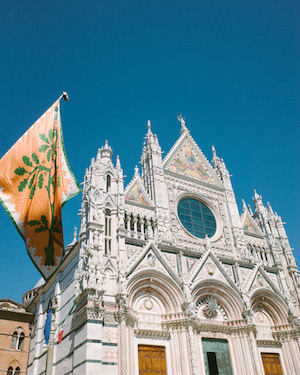

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]

A large cathedral with a bunch of flags flying.


In [168]:
if result is True:
    use_beam_search = False
    image = io.imread('../3.jpg')
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)
    
    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

print(generated_text_prefix)

Tacotron 2 converting the text into a buch of mel-spectrograms, which are then fed into the vocoder, for TTS.

In [162]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

text = generated_text_prefix

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

In [163]:
IPython.display.Audio(waveforms[0:1].cpu().detach(), rate=vocoder.sample_rate)

**Real-Time Prediction** (A combination of the previous functions explained above.)

In [28]:
model_true = load('../HMM_exp/backup/hmm_model_trueF.pkl')
model_false = load('../HMM_exp/backup/hmm_model_falseF.pkl')

In [29]:
sr = 16000         
n_mfcc = 13        
segment_duration = 1.0  
score_diff_threshold = 5.0  

In [30]:
def classify_audio_from_data(audio, model_true=None, model_false=None, sr=16000, n_mfcc=13, score_diff_threshold=5.0):

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T
    true_score = model_true.score(mfcc)
    false_score = model_false.score(mfcc)
    
    score_diff = true_score - false_score
    
    # print(f"True model score: {true_score:.2f}")
    # print(f"False model score: {false_score:.2f}")
    # print(f"Score difference: {score_diff:.2f}")
    
    if score_diff > score_diff_threshold:
        return "on"
    else:
        return "other"


In [31]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
sample_rate = 22050

In [32]:
def synthesize(text_input):
    with torch.inference_mode():
        processed, lengths = processor(text)
        processed = processed.to(device)
        lengths = lengths.to(device)
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)
    return waveforms.cpu().detach(), True

In [33]:
def undistort_image(image):
    
    K = np.array([[1028.1935, 0, 984.2305],
                  [0, 1019.9931, 540.5226],
                  [0, 0, 1]])

    dist_coeffs = np.array([0.0341, -0.0807, 0.0, 0.0, 0.0])

    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w, h), 1, (w, h))
    undistorted = cv2.undistort(image, K, dist_coeffs, None, new_camera_matrix)

    x, y, w, h = roi
    undistorted_cropped = undistorted[y:y+h, x:x+w]

    return undistorted_cropped


In [141]:
def listen_and_detect():
    print("Microphone is active")
    while True:
        print("\nRecording segment...")
        audio = sd.rec(int(segment_duration * sr), samplerate=sr, channels=1, dtype='float32')
        sd.wait()
        audio = audio.flatten()
        
        label = classify_audio_from_data(audio, model_true=model_true, model_false=model_false, sr=sr, n_mfcc=n_mfcc, score_diff_threshold=score_diff_threshold)
        print(f"Segment classified as: {label}")
        
        if label == "on":
            cam = cv2.VideoCapture(0)
            ret, frame = cam.read()
            if ret:
                cv2.imshow('Camera', frame)
                cv2.imwrite('capture.jpg', frame)
            cam.release()
            cv2.destroyAllWindows()
            image = io.imread('capture.jpg')
            pil_image = PIL.Image.fromarray(image)
            image = preprocess(pil_image).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
                
            generated_text_prefix = generation_(prefix_embed, generate1, generate2, model, tokenizer, failsafe=1)
            print(generated_text_prefix)
            return generated_text_prefix            
            break


In [142]:
generated_text_prefix = listen_and_detect()

Microphone is active

Recording segment...
Segment classified as: on
Using Nucleus Sampling. Viable logits: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

A man with headphones on sitting in front of a laptop.
